# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU.

**Make sure you use the best practices you learned in class**.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       dog        car       deer       ship


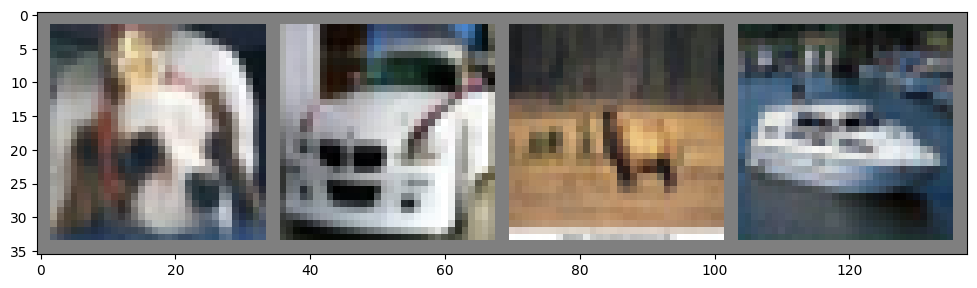

In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value.

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class.
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        #Layer 1 - ConvStage1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same', stride=1, bias=True)

        #Layer 2 - ConvStage2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', stride=1, bias=True)

        #Layer 3 - ConvStage3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same', stride=1, bias=True)

        #Layer 4 - FC1
        self.fc1 = nn.Linear(in_features=1024, out_features=128, bias=True)

        #Layer 5 - FC1
        self.fc2 = nn.Linear(in_features=128, out_features=10, bias=True)

        ##init ReLU func, SoftMax and Pooling
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.maxpool(self.relu(self.conv3(x)))
        # Flatten the output for fully connected layer
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################

criterion = nn.CrossEntropyLoss()
#Adam -  stochastic optimization with adaptive learning + momentum
optimizer = optim.Adam(net.parameters(), lr=0.001)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Epoch 1/10: Training Loss = 1.4583582862868638
Epoch 2/10: Training Loss = 1.0471951548400742
Epoch 3/10: Training Loss = 0.867310969725899
Epoch 4/10: Training Loss = 0.7531752553208709
Epoch 5/10: Training Loss = 0.6711897205208879
Epoch 6/10: Training Loss = 0.6041383285961492
Epoch 7/10: Training Loss = 0.5469125054795724
Epoch 8/10: Training Loss = 0.4896405882123486
Epoch 9/10: Training Loss = 0.4421674240847378
Epoch 10/10: Training Loss = 0.39633524858052166


Text(0, 0.5, 'Loss')

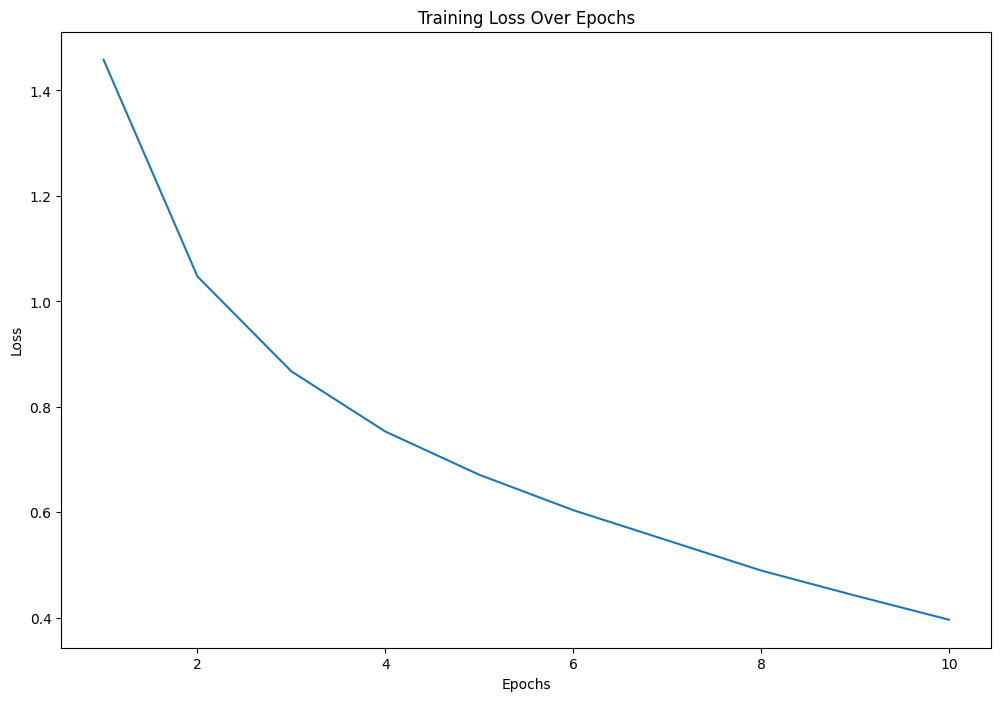

In [6]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        #
#############################################################################
num_epochs = 10

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net =net.to(device)

loss_history = []

#Train the model
for epoch in range(num_epochs):
  epoch_loss = 0.0

  #Set the module in training mode
  net.train()

  # Iterate over batches in the training data
  for img, labels in trainloader:
    img, labels = img.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(img)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()


  # Calculate average loss for the epoch
  average_loss = epoch_loss / len(trainloader)
  loss_history.append(average_loss)
  print(f'Epoch {epoch+1}/{num_epochs}: Training Loss = {loss_history[-1]}')

#plot loss as function of epochs
plt.plot(range(1,num_epochs+1), loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)**

In [7]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        #
#############################################################################
# Set the model to evaluation mode
net.eval()

# Iterate over batches in the test data
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = net(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[labels[i]][predicted[i]] += 1

# Calculate accuracy using confusion matrix
model_accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix) * 100

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 74.87%


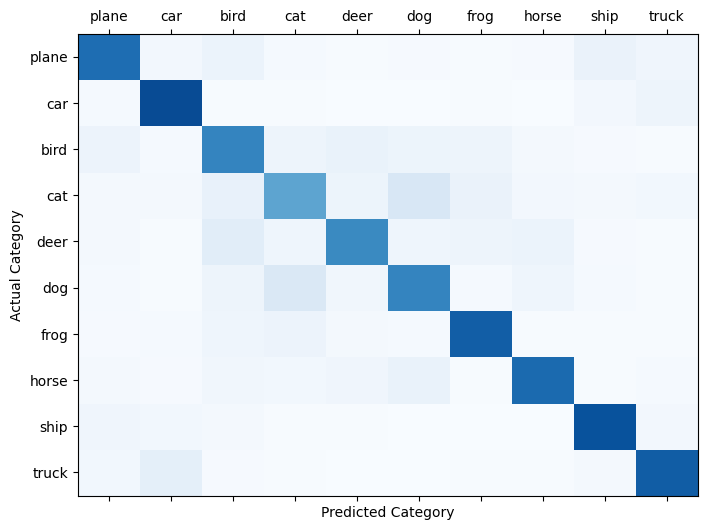

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:**
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** Those are the parameters I experimented with:

**Optimizer** - Initially, I employed Stochastic Gradient Descent (SGD) and experimented with different learning rates and momentum values. However, I encountered slow convergence of the loss function, resulting in low accuracy. Subsequently, I switched to the Adam optimizer, which improved the performance.

**kernel size** - I started with 3X3 kernal which demonstrated good performance. Then I tried a bigger size - 5X5. Despite achieving similar accuracy, the larger kernel size resulted in longer execution times.

**number of convolution layers and FC layers** - First, I configured the model with 5 convolution layers and 3 fully connected (FC) layers. However, I observed slow runtime, prompting me to iteratively reduce the number of layers until meeting the runtime constrain.



##**Question:**
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:**  The accuracy test provide only the accuracy of the entire model. It might not be sufficient for imbalanced datasets. For example, in a scenario where one class dominates the dataset, a classifier might achieve high accuracy by simply predicting the dominant class.

On the other hand, The confusion matrix is a powerfull and more detailed tool for evaluating the performance of a classification model. It provides us a clasification of the outcome into **4 groops per class**: True Positives, False Postives, True Negatives, False Negatives (allowing for a deeper understanding of its strengths and weaknesses). In this method we can see whether the classifier is able to correctly predict all classes, or it has difficulty with certain classes. Moreover, we can see which class is mixed up with other class and is a weakness in the model.


# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs.

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images.

In [11]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [12]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [13]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"

datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [14]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 1200x800 with 0 Axes>

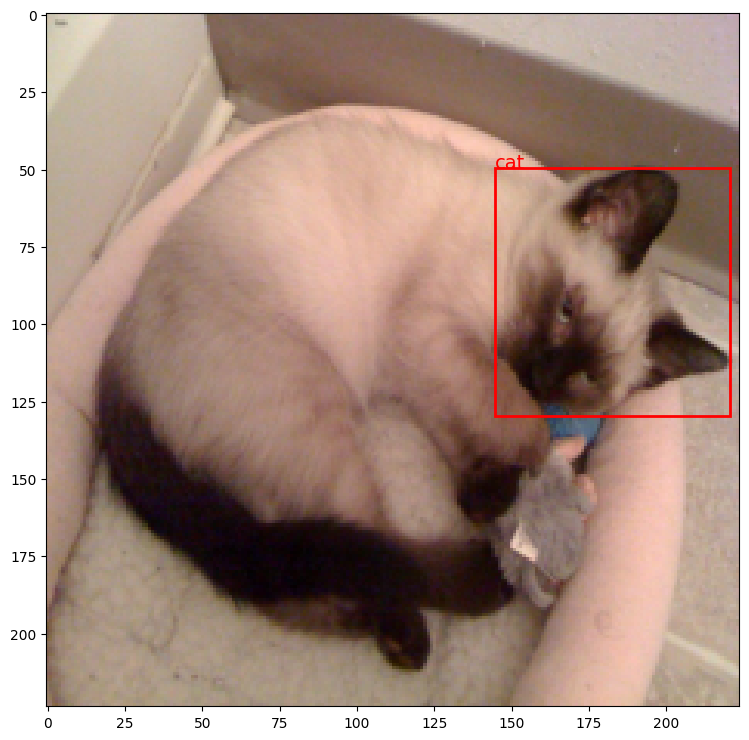

In [15]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################

        # Load pretrained ResNet-18 and remove the last fully connected layer
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Freeze ResNet-18 backbone
        for param in self.features.parameters():
            param.requires_grad = False

        # Define classification model
        self.classification_scores = nn.Sequential(nn.Flatten(),
            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes)
        )

        # Define detection model
        self.detection_bbox = nn.Sequential(nn.Flatten(),
            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4, bias=True)
        )

        # Lists to store metrics for plotting
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_iou_history = []
        self.val_iou_history = []

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        x = self.features(images)
        classification_scores = self.classification_scores(x)
        bounding_box = self.detection_bbox(x)

        return classification_scores, bounding_box

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set.
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [17]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score

            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################

                inputs = sample['image'].to(device)
                labels = sample['label'].to(device)
                bboxes = sample['bbox'].to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                  out_labels, out_bboxes = model(inputs)
                  loss_cls = criterion_cls(out_labels, labels)
                  loss_bbox = criterion_bbox(out_bboxes, bboxes)

                  # Backward pass and optimization
                  if phase == 'train':
                    loss_cls.backward()
                    loss_bbox.backward()
                    optimizer.step()

                running_loss += loss_cls.item() * inputs.size(0) + loss_bbox.item() * inputs.size(0)
                _, preds_cls = torch.max(out_labels, 1)
                running_corrects += torch.sum(preds_cls == labels.data)

                for pred_box, true_box in zip(out_bboxes, bboxes):
                  iou += bb_intersection_over_union(pred_box, true_box)


                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]

            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            ####################################################################
            if phase == 'train':
                model.train_loss_history.append(epoch_loss)
                model.train_acc_history.append(epoch_acc.to("cpu"))
                model.train_iou_history.append(iou)
            else:
                model.val_loss_history.append(epoch_loss)
                model.val_acc_history.append(epoch_acc.to("cpu"))
                model.val_iou_history.append(iou)

            ####################################################################

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [18]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()

parameters = filter(lambda p: p.requires_grad, cnn.parameters())
optimizer = optim.Adam(parameters, lr=0.001)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [19]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------


train Loss: 0.3657  |  Acc: 0.8616  |  IOU: 0.5973
val Loss: 0.1120  |  Acc: 0.9684  |  IOU: 0.6700
Epoch 2/10
----------
train Loss: 0.1139  |  Acc: 0.9686  |  IOU: 0.7065
val Loss: 0.0468  |  Acc: 1.0000  |  IOU: 0.7167
Epoch 3/10
----------
train Loss: 0.0570  |  Acc: 0.9921  |  IOU: 0.7325
val Loss: 0.0489  |  Acc: 0.9873  |  IOU: 0.7277
Epoch 4/10
----------
train Loss: 0.0588  |  Acc: 0.9858  |  IOU: 0.7456
val Loss: 0.0335  |  Acc: 0.9873  |  IOU: 0.7383
Epoch 5/10
----------
train Loss: 0.0499  |  Acc: 0.9827  |  IOU: 0.7554
val Loss: 0.0319  |  Acc: 0.9873  |  IOU: 0.7427
Epoch 6/10
----------
train Loss: 0.0634  |  Acc: 0.9764  |  IOU: 0.7643
val Loss: 0.0366  |  Acc: 0.9873  |  IOU: 0.7363
Epoch 7/10
----------
train Loss: 0.0328  |  Acc: 0.9937  |  IOU: 0.7629
val Loss: 0.0346  |  Acc: 0.9873  |  IOU: 0.7529
Epoch 8/10
----------
train Loss: 0.0297  |  Acc: 0.9937  |  IOU: 0.7722
val Loss: 0.0278  |  Acc: 0.9937  |  IOU: 0.7484
Epoch 9/10
----------
train Loss: 0.0248  |  A

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 1200x800 with 0 Axes>

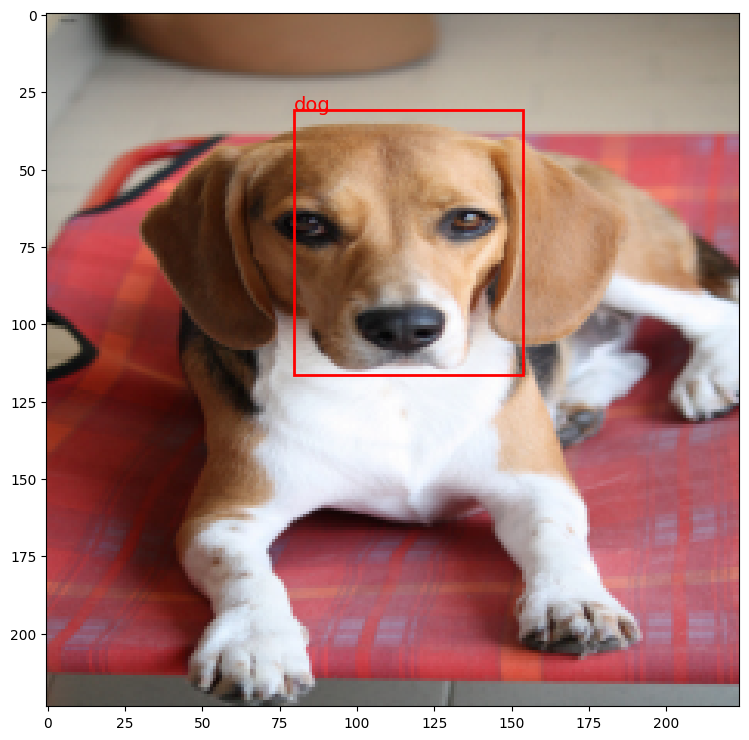

In [20]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

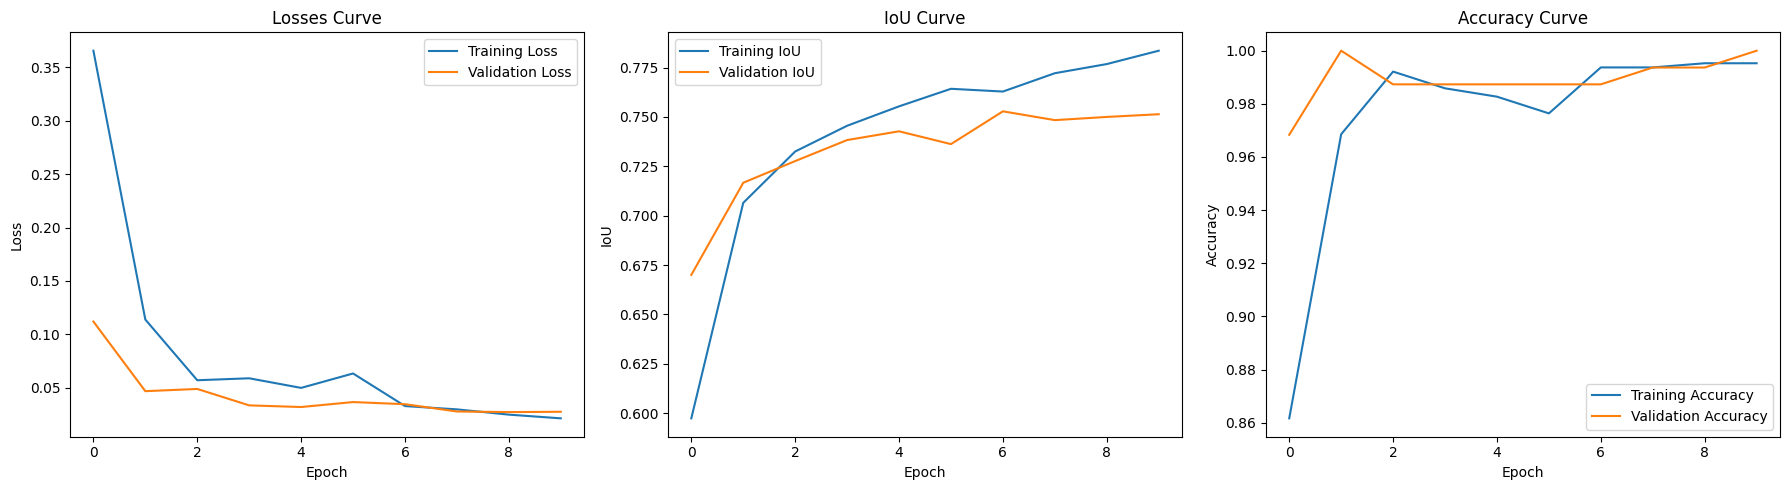

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))


# Plot loss history: plot loses as function of epochs
axs[0].plot(best_model.train_loss_history, label='Training Loss')
axs[0].plot(best_model.val_loss_history, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Losses Curve')
axs[0].legend()

# Plot IoU hostory as function of epochs
axs[1].plot(best_model.train_iou_history, label='Training IoU')
axs[1].plot(best_model.val_iou_history, label='Validation IoU')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('IoU')
axs[1].set_title('IoU Curve')
axs[1].legend()

# Plot accuracy as function of of epochs
axs[2].plot(best_model.train_acc_history, label='Training Accuracy')
axs[2].plot(best_model.val_acc_history, label='Validation Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy Curve')
axs[2].legend()


plt.tight_layout()
plt.show()


We built the NN based on pretrained resnet18 which outputs the predicted label and a bounding box coordinates. We can see that training and validation accuracy is very high from the beginning. This is because most of the weights are already trained and in each epoch we only fine-tune the last (and untrained) layer.